# Vignette

Exemplary analysis of the PBMC3K single-cell RNA dataset.

In [1]:
%%capture --no-display
%pip install scanpy

In [2]:
import os
import math
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
from keggtools import (
    Pathway,
    Enrichment,
    EnrichmentResult,
    Resolver,
    Renderer,
    IMMUNE_SYSTEM_PATHWAYS,
    plot_enrichment_result,
)
from IPython.display import Image, display

# Used folders
figure_dir = os.path.join(os.getcwd(), "figures")

# Global settings
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

# Ignore all warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Load preprocessed PMBC3K dataset

In [3]:
adata = sc.datasets.pbmc3k_processed()

### Plot UMAP with cluster annotations

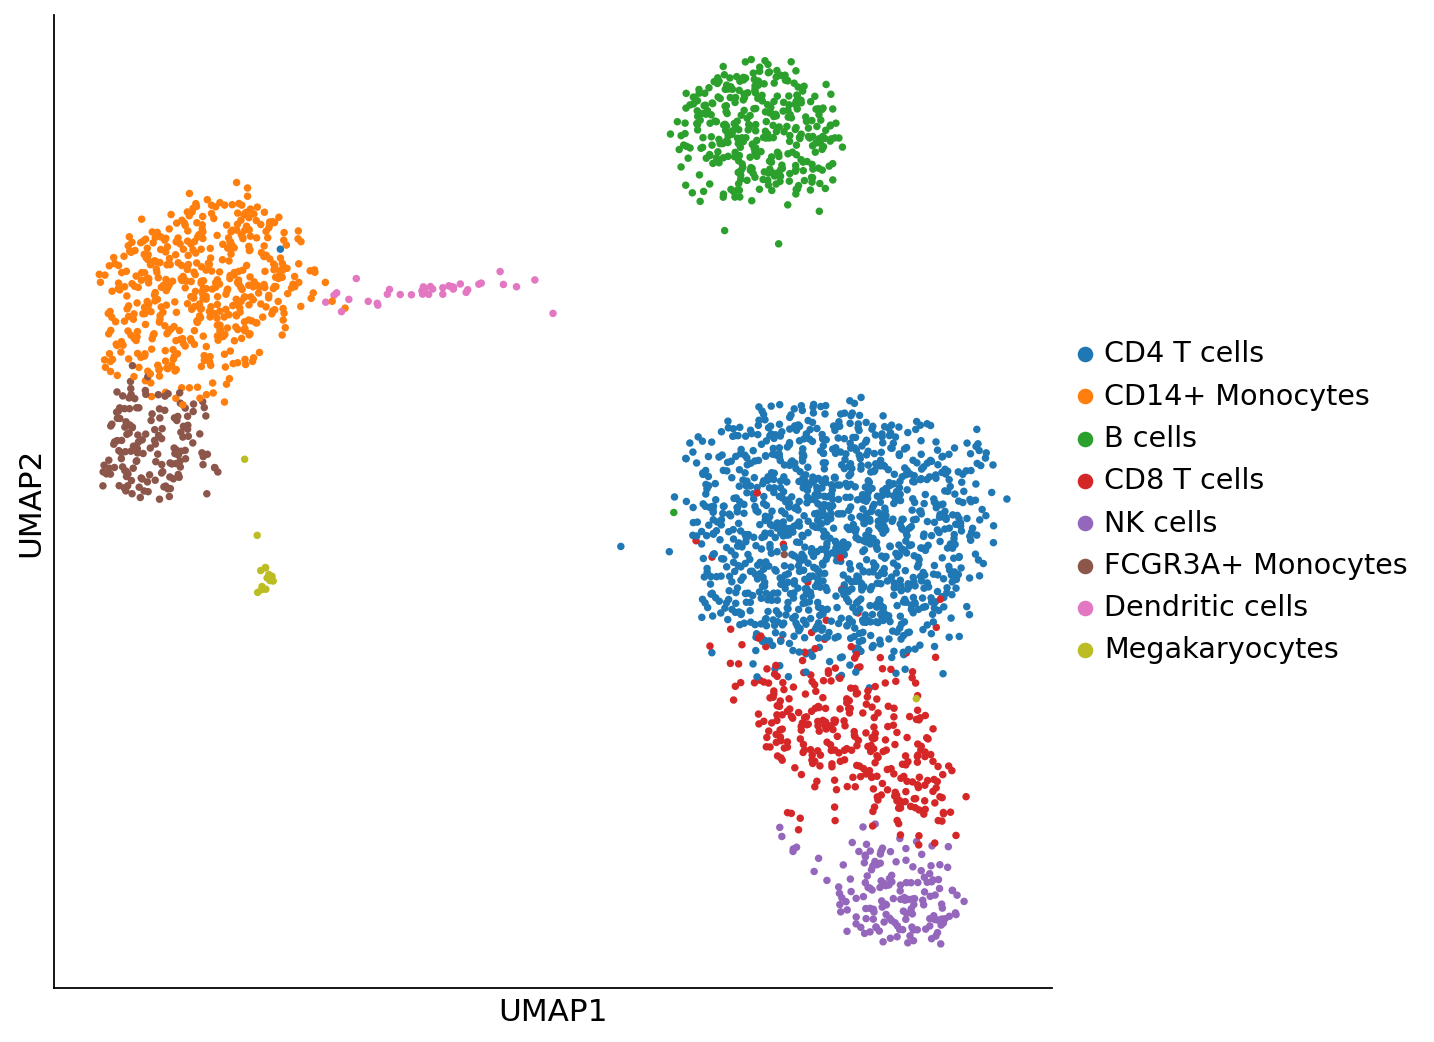

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
sc.pl.umap(adata, color="louvain", legend_loc="right margin", title="", frameon=True, ax=ax, show=False)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
fig.savefig(os.path.join(figure_dir, "figure2.png"))

### Differential analysis results to pandas dataframe

In [5]:
sc.tl.rank_genes_groups(adata, "louvain", method="wilcoxon", n_genes=100)

In [6]:
# Export diff exp data
diffexp_df = sc.get.rank_genes_groups_df(adata, group="NK cells", pval_cutoff=0.05)
diffexp_df.head()

,names,scores,logfoldchanges,pvals,pvals_adj
0,NKG7,20.181747,5.623642,1.416465e-90,1.942540e-86
1,GZMB,19.738880,6.650631,9.996947e-87,6.854906e-83
2,PRF1,19.434803,5.433477,3.919145e-84,1.791572e-80
3,GNLY,19.357994,6.657686,1.745530e-83,5.984549e-80
4,CTSW,18.578722,3.808060,4.777493e-77,1.310371e-73


### Perform KEGGTOOLS enrichment analysis

In [7]:
organism_id: str = "hsa"

In [8]:
from keggtools.utils import merge_entrez_geneid

In [9]:
diffexp_df = merge_entrez_geneid(diffexp_df)
diffexp_df.head()

,names,scores,logfoldchanges,pvals,pvals_adj,symbol,entrez
0,NKG7,20.181747,5.623642,1.416465e-90,1.942540e-86,NKG7,4818
1,GZMB,19.738880,6.650631,9.996947e-87,6.854906e-83,GZMB,3002
2,PRF1,19.434803,5.433477,3.919145e-84,1.791572e-80,PRF1,5551
3,GNLY,19.357994,6.657686,1.745530e-83,5.984549e-80,GNLY,10578
4,CTSW,18.578722,3.808060,4.777493e-77,1.310371e-73,CTSW,1521


In [10]:
# Init resolver instance
resolver: Resolver = Resolver()
pathway_list: list[Pathway] = []

# Download all immune system pathways
for number, _ in IMMUNE_SYSTEM_PATHWAYS.items():
    pathway_list.append(resolver.get_pathway(organism=organism_id, code=number))

In [11]:
# Init enrichment from list of immune system pathways
analysis: Enrichment = Enrichment(pathways=pathway_list)
analysis_result: list[EnrichmentResult] = analysis.run_analysis(gene_list=list(diffexp_df["entrez"]))
result_df: pd.DataFrame = analysis.to_dataframe()

# Filter out pathways with no genes found
result_df = result_df[result_df["study_count"] > 0]

# Print out result
result_df.sort_values(by="pvalue", ascending=True).head()

,pathway_name,pathway_title,pathway_id,study_count,pathway_genes,pvalue,found_genes
8,path:hsa04650,Natural killer cell mediated cytotoxicity,04650,17,134,0.000071,"5551,3133,7535,117157,10870,919,2207,7305,3002..."
4,path:hsa04621,NOD-like receptor signaling pathway,04621,3,189,0.042361,"6352,10628,1535"
0,path:hsa04640,Hematopoietic cell lineage,04640,1,100,0.085921,924
9,path:hsa04612,Antigen processing and presentation,04612,7,81,0.094117,"567,3105,3106,3107,3133,3824,2923"
10,path:hsa04660,T cell receptor signaling pathway,04660,2,122,0.173754,"7535,919"


### Plot results of enrichment analysis

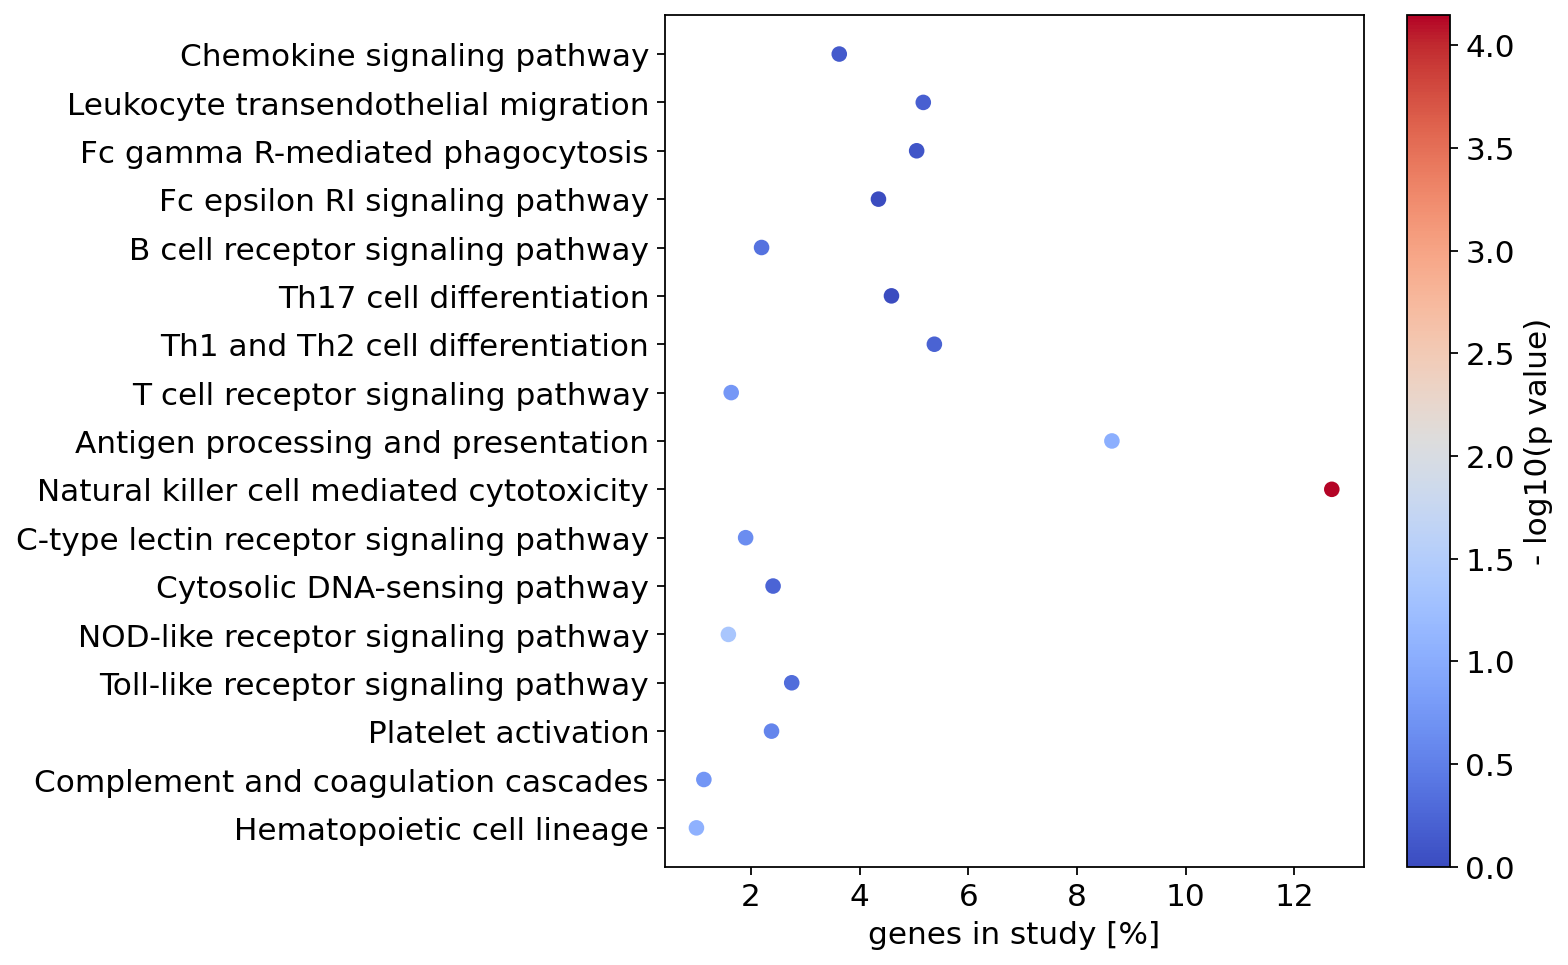

In [12]:
fig, ax = plt.subplots(figsize=(7, 7))
plot_enrichment_result(analysis, ax=ax)
fig.savefig(os.path.join(figure_dir, "figure4.png"), bbox_inches="tight")

### Plot pathway

* "Antigen processing and presentation" (hsa:04612) show a significant p value

In [13]:
pathway: Pathway = resolver.get_pathway(organism=organism_id, code="04650")

In [14]:
# diffexp_df[["entrez"]] = diffexp_df[["entrez"]].astype(int)
overlay: dict = dict(zip(list(diffexp_df["entrez"]), list(diffexp_df["logfoldchanges"]), strict=True))

In [15]:
renderer: Renderer = Renderer(kegg_pathway=pathway, gene_dict=overlay, cache_or_resolver=resolver.storage)
renderer.render(display_unlabeled_genes=False)

In [16]:
# Save dot string to file
with open(os.path.join(figure_dir, "figure5.dot"), "w") as file_obj:
    file_obj.write(renderer.to_string())

# Save binary data to file
renderer.to_file(filename=os.path.join(figure_dir, "figure5.png"), extension="png")

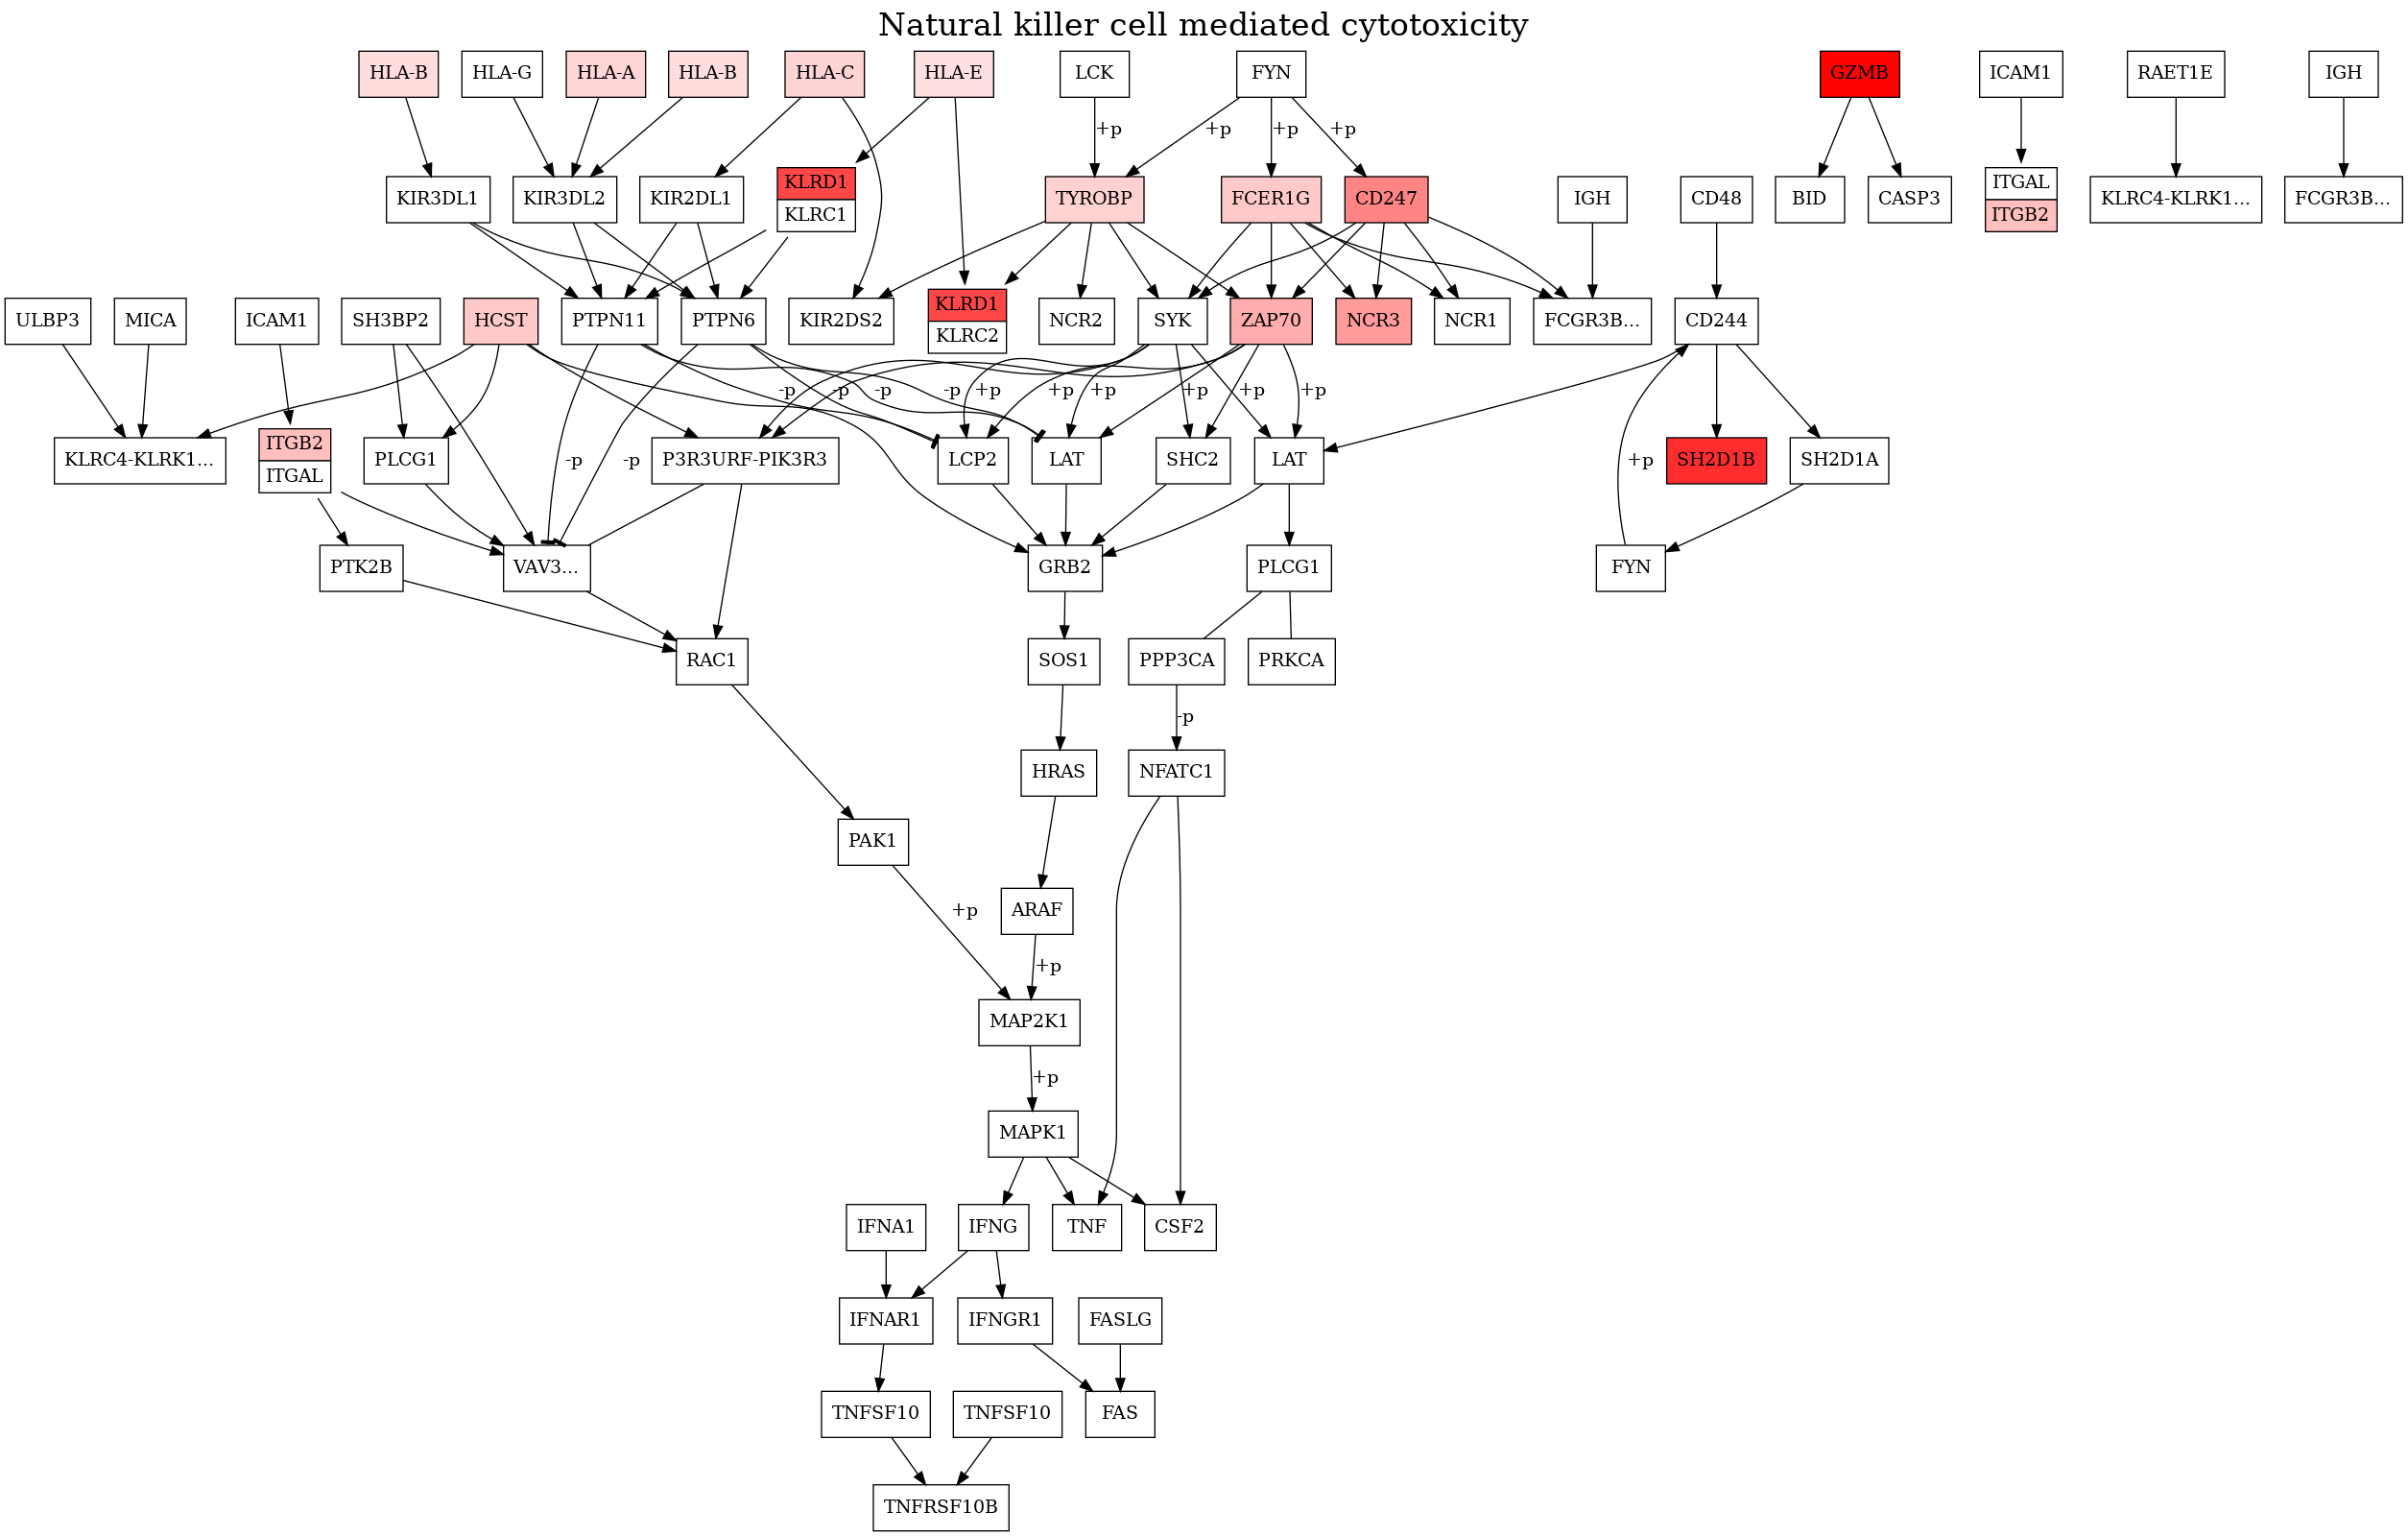

In [17]:
# Display image
img: Image = Image(os.path.join(figure_dir, "figure5.png"))
display(img)

### Plot with KEGG prerendered image

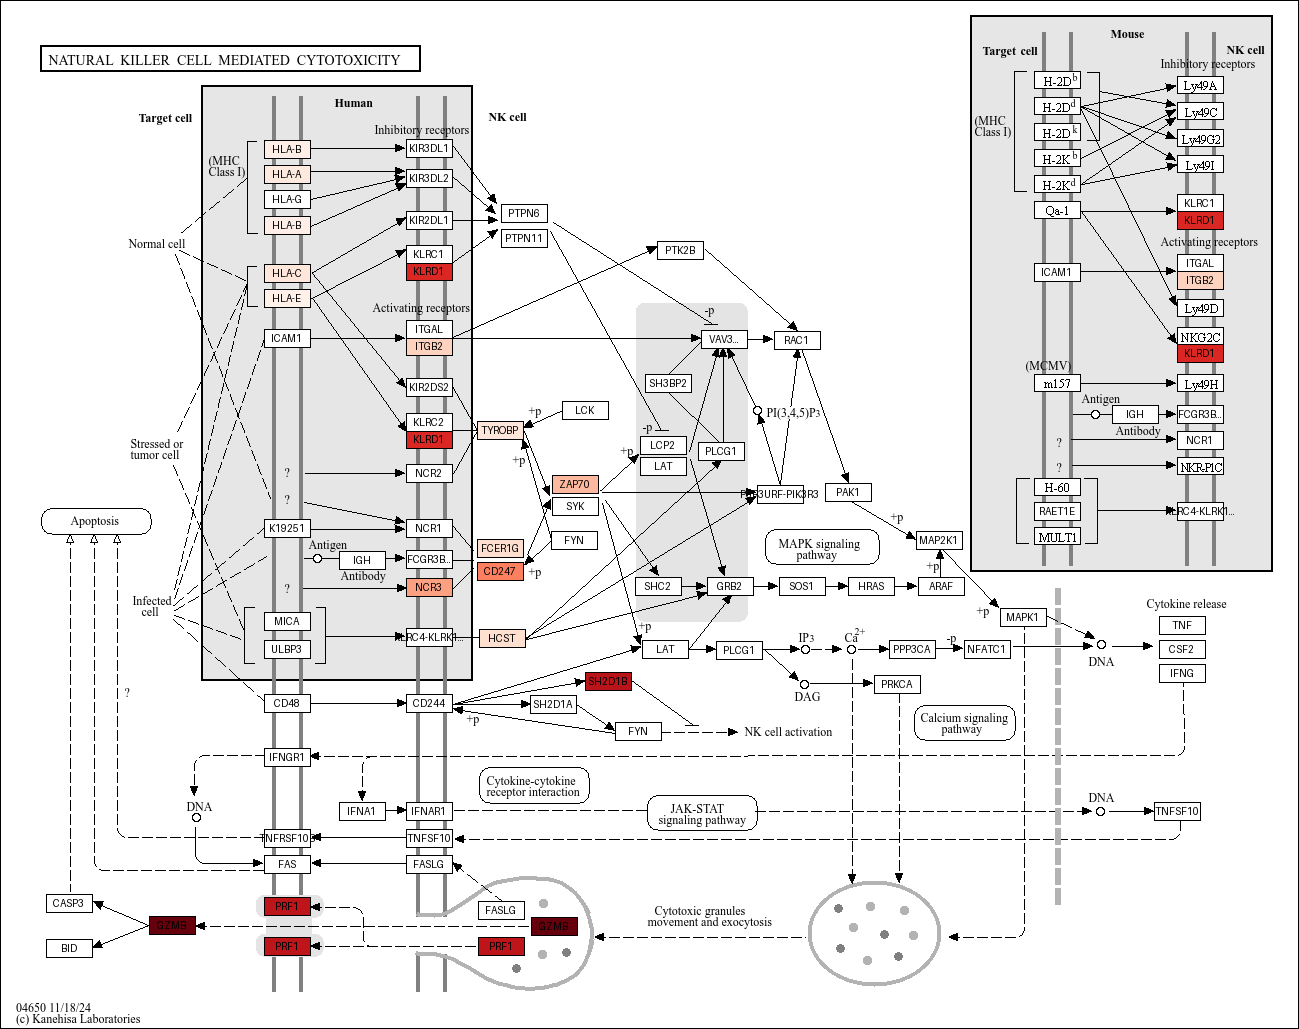

In [18]:
from keggtools import render_overlay_image

display(
    render_overlay_image(
        pathway=Resolver().get_pathway(organism="hsa", code="04650"),
        overlay_dict=overlay,
        cmap="Reds",
    )
)